In [14]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
def image_to_tensor(image_filepath, image_dimension=128):
    img = Image.open(image_filepath).convert('RGB')

    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)
    return img.to(dvc, torch.float)

style_image = image_to_tensor('./images/style.jpg')
content_image = image_to_tensor('./images/content.jpg')

In [16]:
vgg19_model = torchvision.models.vgg19(pretrained=True).to(dvc)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
vgg19_model = vgg19_model.features 

In [18]:
## pararmeter 고정
for param in vgg19_model.parameters():
    param.requires_grad_(False)

In [19]:
## 모델 변형

conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d' : 
        vgg19_model[i] = nn.AvgPool2d(
            kernel_size=vgg19_model[i].kernel_size,
            stride=vgg19_model[i].stride,
            padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)
print(conv_indices)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [20]:
## 스타일 손실과 컨텐츠 손실을 계산할 conv 정보
layers = {1:'s', 2:'s', 3:'s', 4:'sc', 5:'s'}

In [21]:
## 네트워크 변형
vgg_layers = nn.ModuleList(vgg19_model)
last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


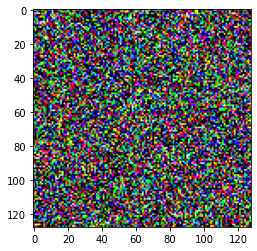

In [22]:
ip_image = content_image.clone()
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1))

In [23]:
num_epochs = 300 
wt_style = 1e6
wt_content = 1
style_losses = []
content_losses = [] 
opt = optim.Adam([ip_image.requires_grad_()], lr=0.1)

In [24]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t()) ## 내적 계산
    return gram_mat.div(num_batch * num_channels * width * height) ## 특징 맵 개수 x 특징맵 너비 x 특징맵 높이를 나누어 정규화 

epoch number 50
style loss = 0.5148386359214783, content loss = 1.6605980396270752


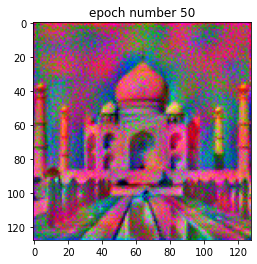

epoch number 100
style loss = 0.38481593132019043, content loss = 1.396036982536316


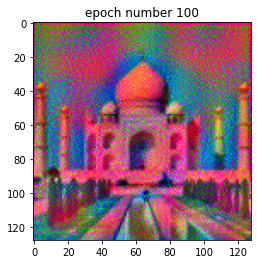

epoch number 150
style loss = 0.34511250257492065, content loss = 1.3423573970794678


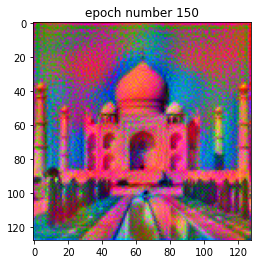

epoch number 200
style loss = 0.3308868408203125, content loss = 1.3156434297561646


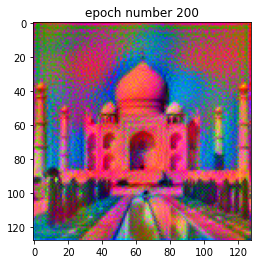

epoch number 250
style loss = 0.32555899024009705, content loss = 1.2997901439666748


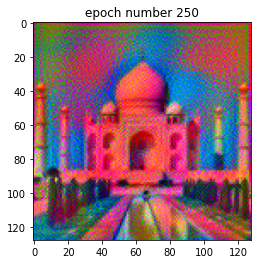

epoch number 300
style loss = 0.3235270380973816, content loss = 1.2886877059936523


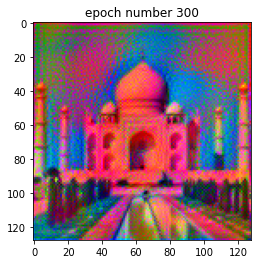

In [25]:
for curr_epoch in range(1, num_epochs+1):
    ip_image.data.clamp_(0, 1)
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0 

    for k in layers.keys():
        if 'c' in layers[k]: ## content loss
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()  #### .detach()는 훈련가능하지 않고, 고정값임을 의미 !!
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        
        if 's' in layers[k] : ## style loss
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_content_loss *= wt_content
    epoch_style_loss *= wt_style 
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward() 

    if curr_epoch % 50 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        style_losses += [epoch_style_loss]
        content_losses += [epoch_content_loss]
    
    opt.step()